In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from aptr.database import RnaDB
from aptr.oor_distance import oor_distance

In [3]:
db = RnaDB()

0.9988417733736568 sequences remain after trimming
0.3807026574866482 sequences remain after filtering


In [4]:
# How many genomes do we have?

db.db["genome"].nunique()

2172

In [5]:
# For each genome, get the difference between max and min oor distance

best_spreads = (
    db.db["oor_distance"].groupby(db.db["genome"]).apply(lambda x: x.max() - x.min()).sort_values(ascending=False)
)
best_spreads.head(50)

genome
2026188.14     0.996549
2704462.3      0.992947
39488.252      0.989904
986075.10      0.985696
427920.3       0.983266
1805475.3      0.982534
2594004.3      0.982248
315271.3       0.976720
2561898.4      0.974824
2518973.4      0.972254
227.4          0.972012
2172099.4      0.970779
104609.11      0.970642
313594.4       0.969721
2026780.183    0.968707
1471761.3      0.967695
1591408.3      0.967685
1805431.3      0.964967
365349.7       0.964875
2014871.3      0.963191
40216.65       0.962699
1628085.168    0.961591
1329796.4      0.958898
649639.5       0.958895
35841.11       0.958620
1890302.151    0.958438
1278073.14     0.953559
2038116.16     0.953443
1112204.3      0.953289
768706.3       0.952117
698948.3       0.950813
320778.9       0.950400
1796652.22     0.948914
1450.13        0.948441
2758440.3      0.946844
190893.112     0.944428
1347342.6      0.944378
313595.4       0.943688
1158606.4      0.942665
663.613        0.942591
1300343.5      0.942562
1232383.3

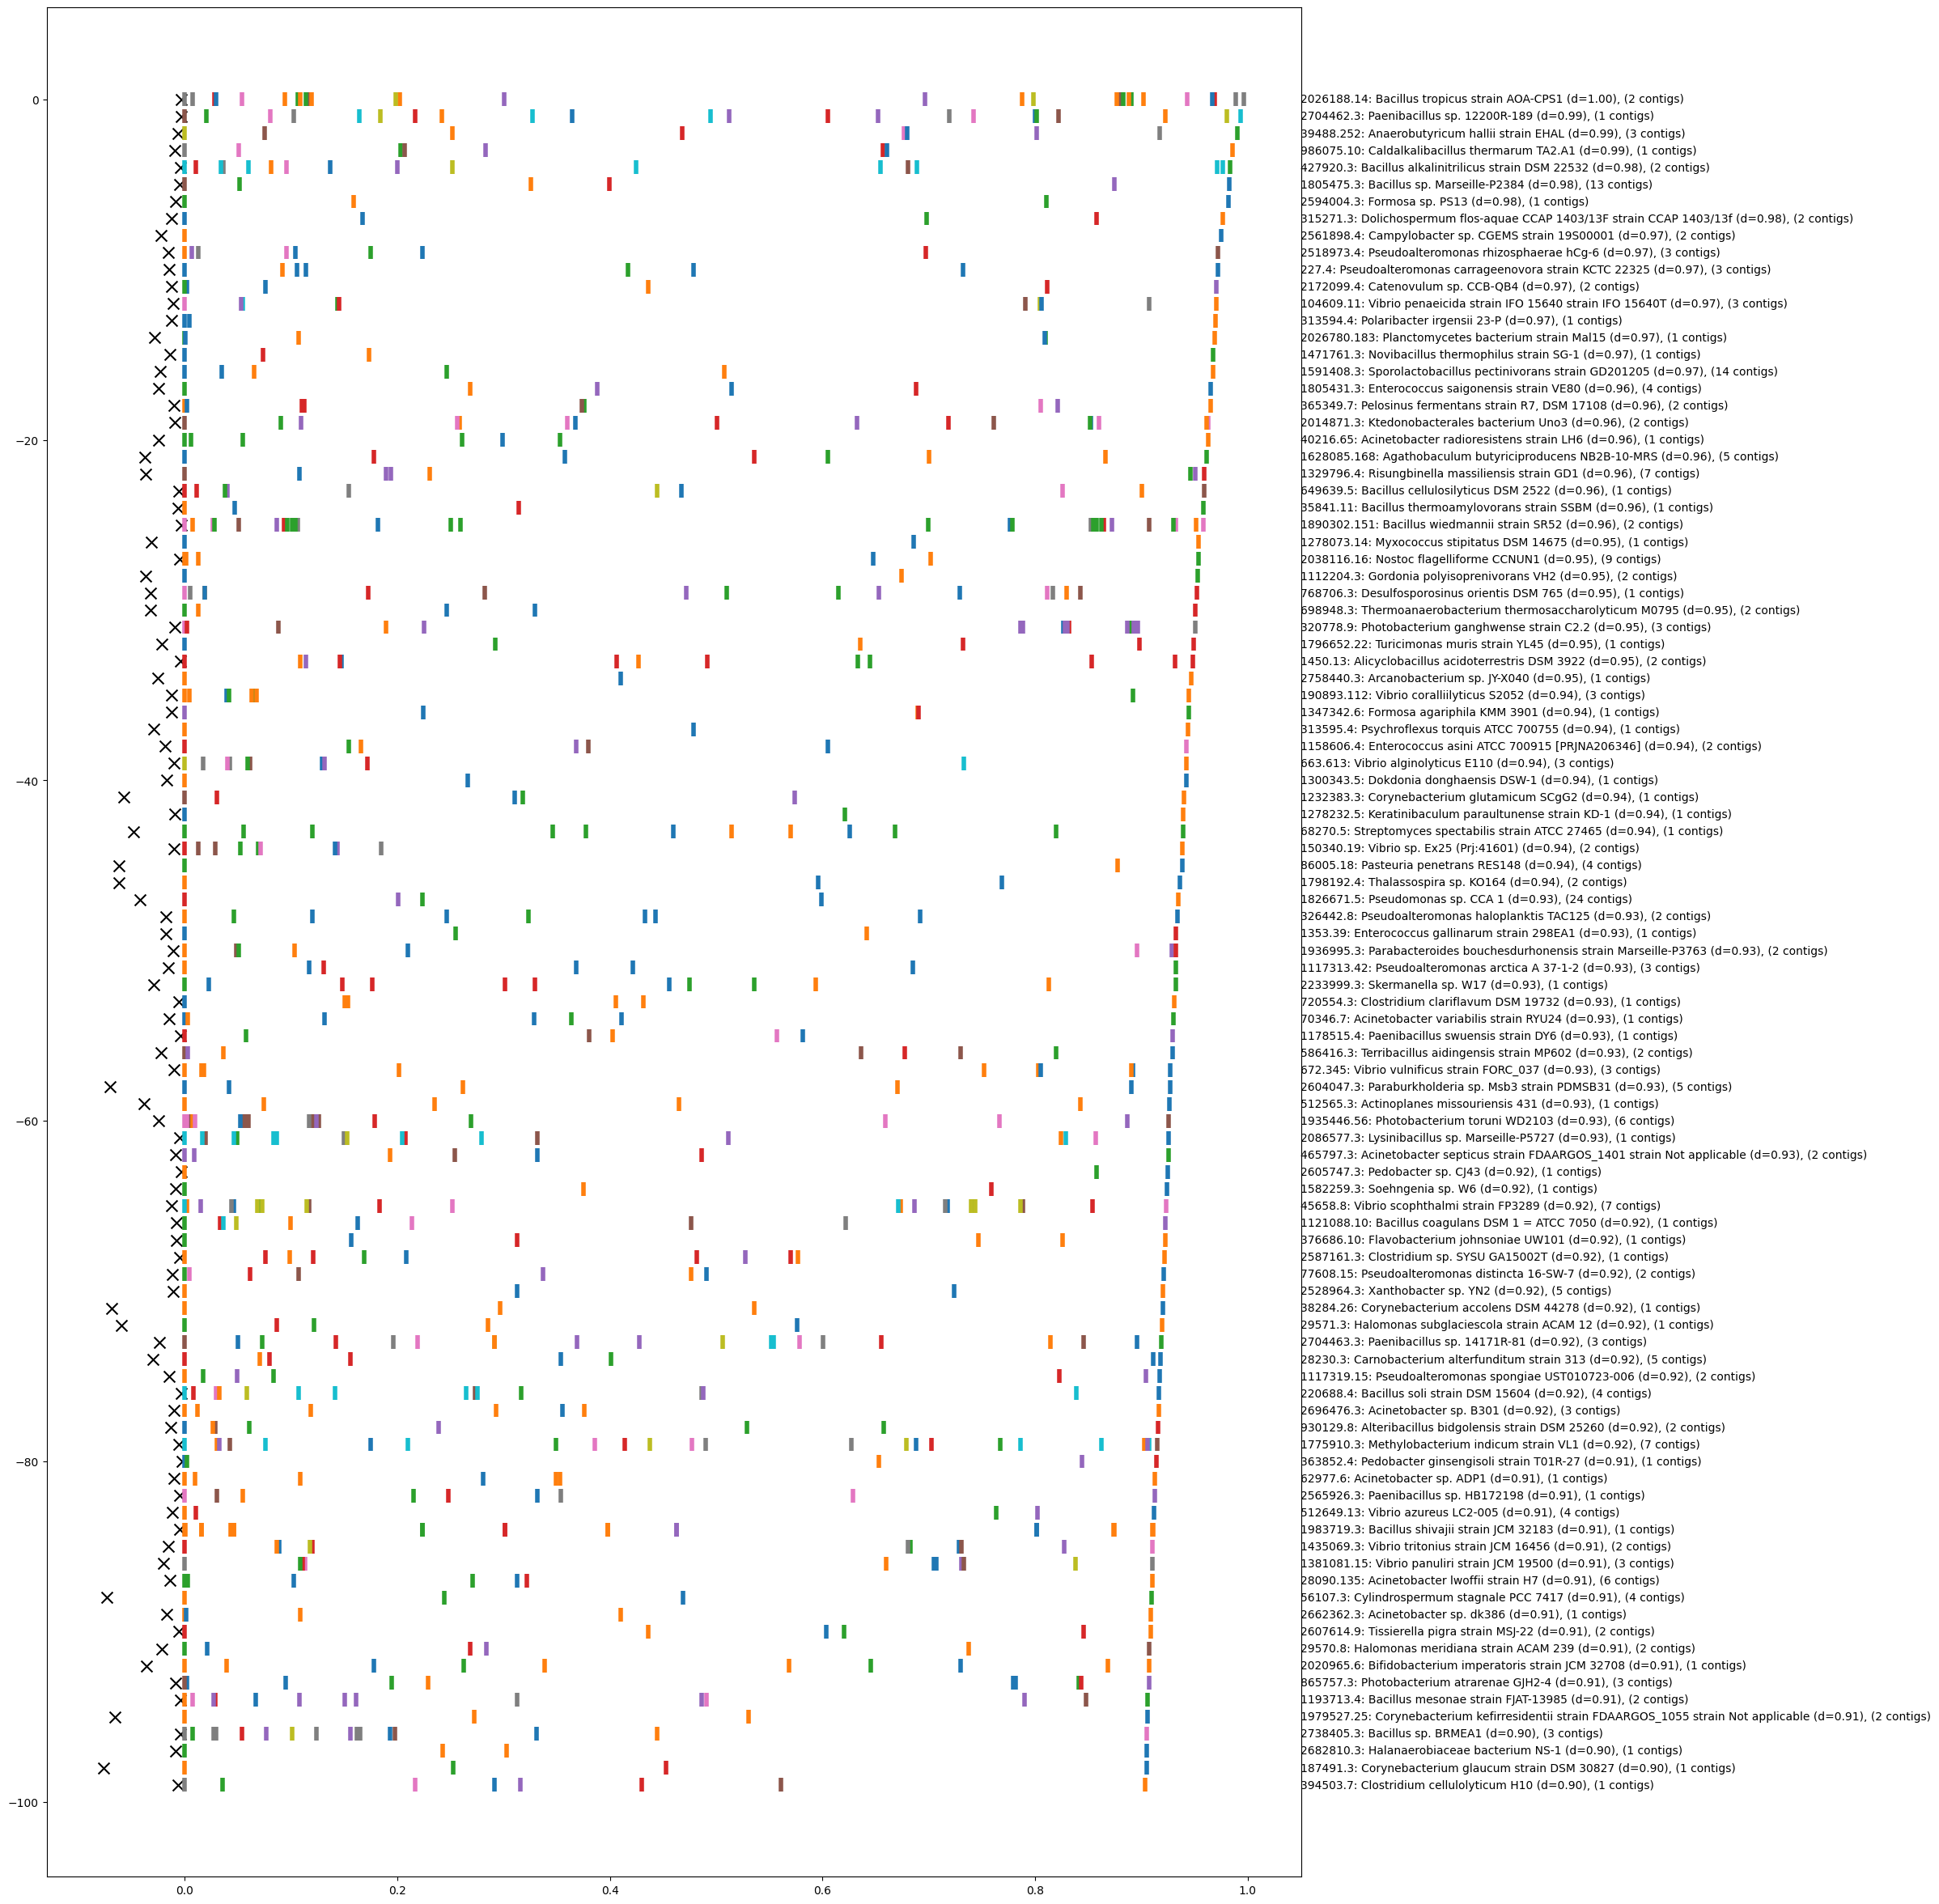

In [6]:
from matplotlib import cm


def visualize_genome(gid, height=0, dist=None):
    g = db[gid]
    colors = cm.tab10(g["md5"].astype("category").cat.codes)
    name = g["genome_name"].iloc[0]
    n_contigs = g["n_contigs"].iloc[0]
    offset = g["oor_distance"].min()
    plt.vlines(g["oor_distance"] - offset, -height - 0.4, -height + 0.4, colors=colors, lw=4)
    plt.scatter(-offset, -height, color="black", s=100, marker="x")
    plt.text(1.05, -height, f"{gid}: {name} (d={dist:.2f}), ({n_contigs} contigs)", ha="left", va="center")


fig, ax = plt.subplots(figsize=(20, 30))
for i, gid in enumerate(best_spreads.iloc[:100].index):
    visualize_genome(gid, i, best_spreads[gid])
# visualize_genome("1566358.3")

In [26]:
# Which of these is a complete genome?

# First, store this as a tsv file
best_spreads.iloc[:100].to_csv("best_spreads.tsv", sep="\t")

# Then, call p3-get-genome-data to see if they're complete
!p3-get-genome-data --attr genome_status --col 1 < best_spreads.tsv > best_spreads_complete.tsv

# Get the complete genomes
complete_genomes = pd.read_csv("best_spreads_complete.tsv", sep="\t", index_col=0, dtype={"genome": str})
complete_genomes = complete_genomes[complete_genomes["genome.genome_status"] == "Complete"]

# Delete the file
os.remove("best_spreads.tsv")
os.remove("best_spreads_complete.tsv")

# Visualize the complete genomes
complete_genomes

,oor_distance,genome.genome_status
genome,,
2026188.14,0.996549,Complete
2704462.3,0.992947,Complete
39488.252,0.989904,Complete
986075.10,0.985696,Complete
2594004.3,0.982248,Complete
...,...,...
865757.3,0.907111,Complete
1979527.25,0.905388,Complete
2682810.3,0.904775,Complete


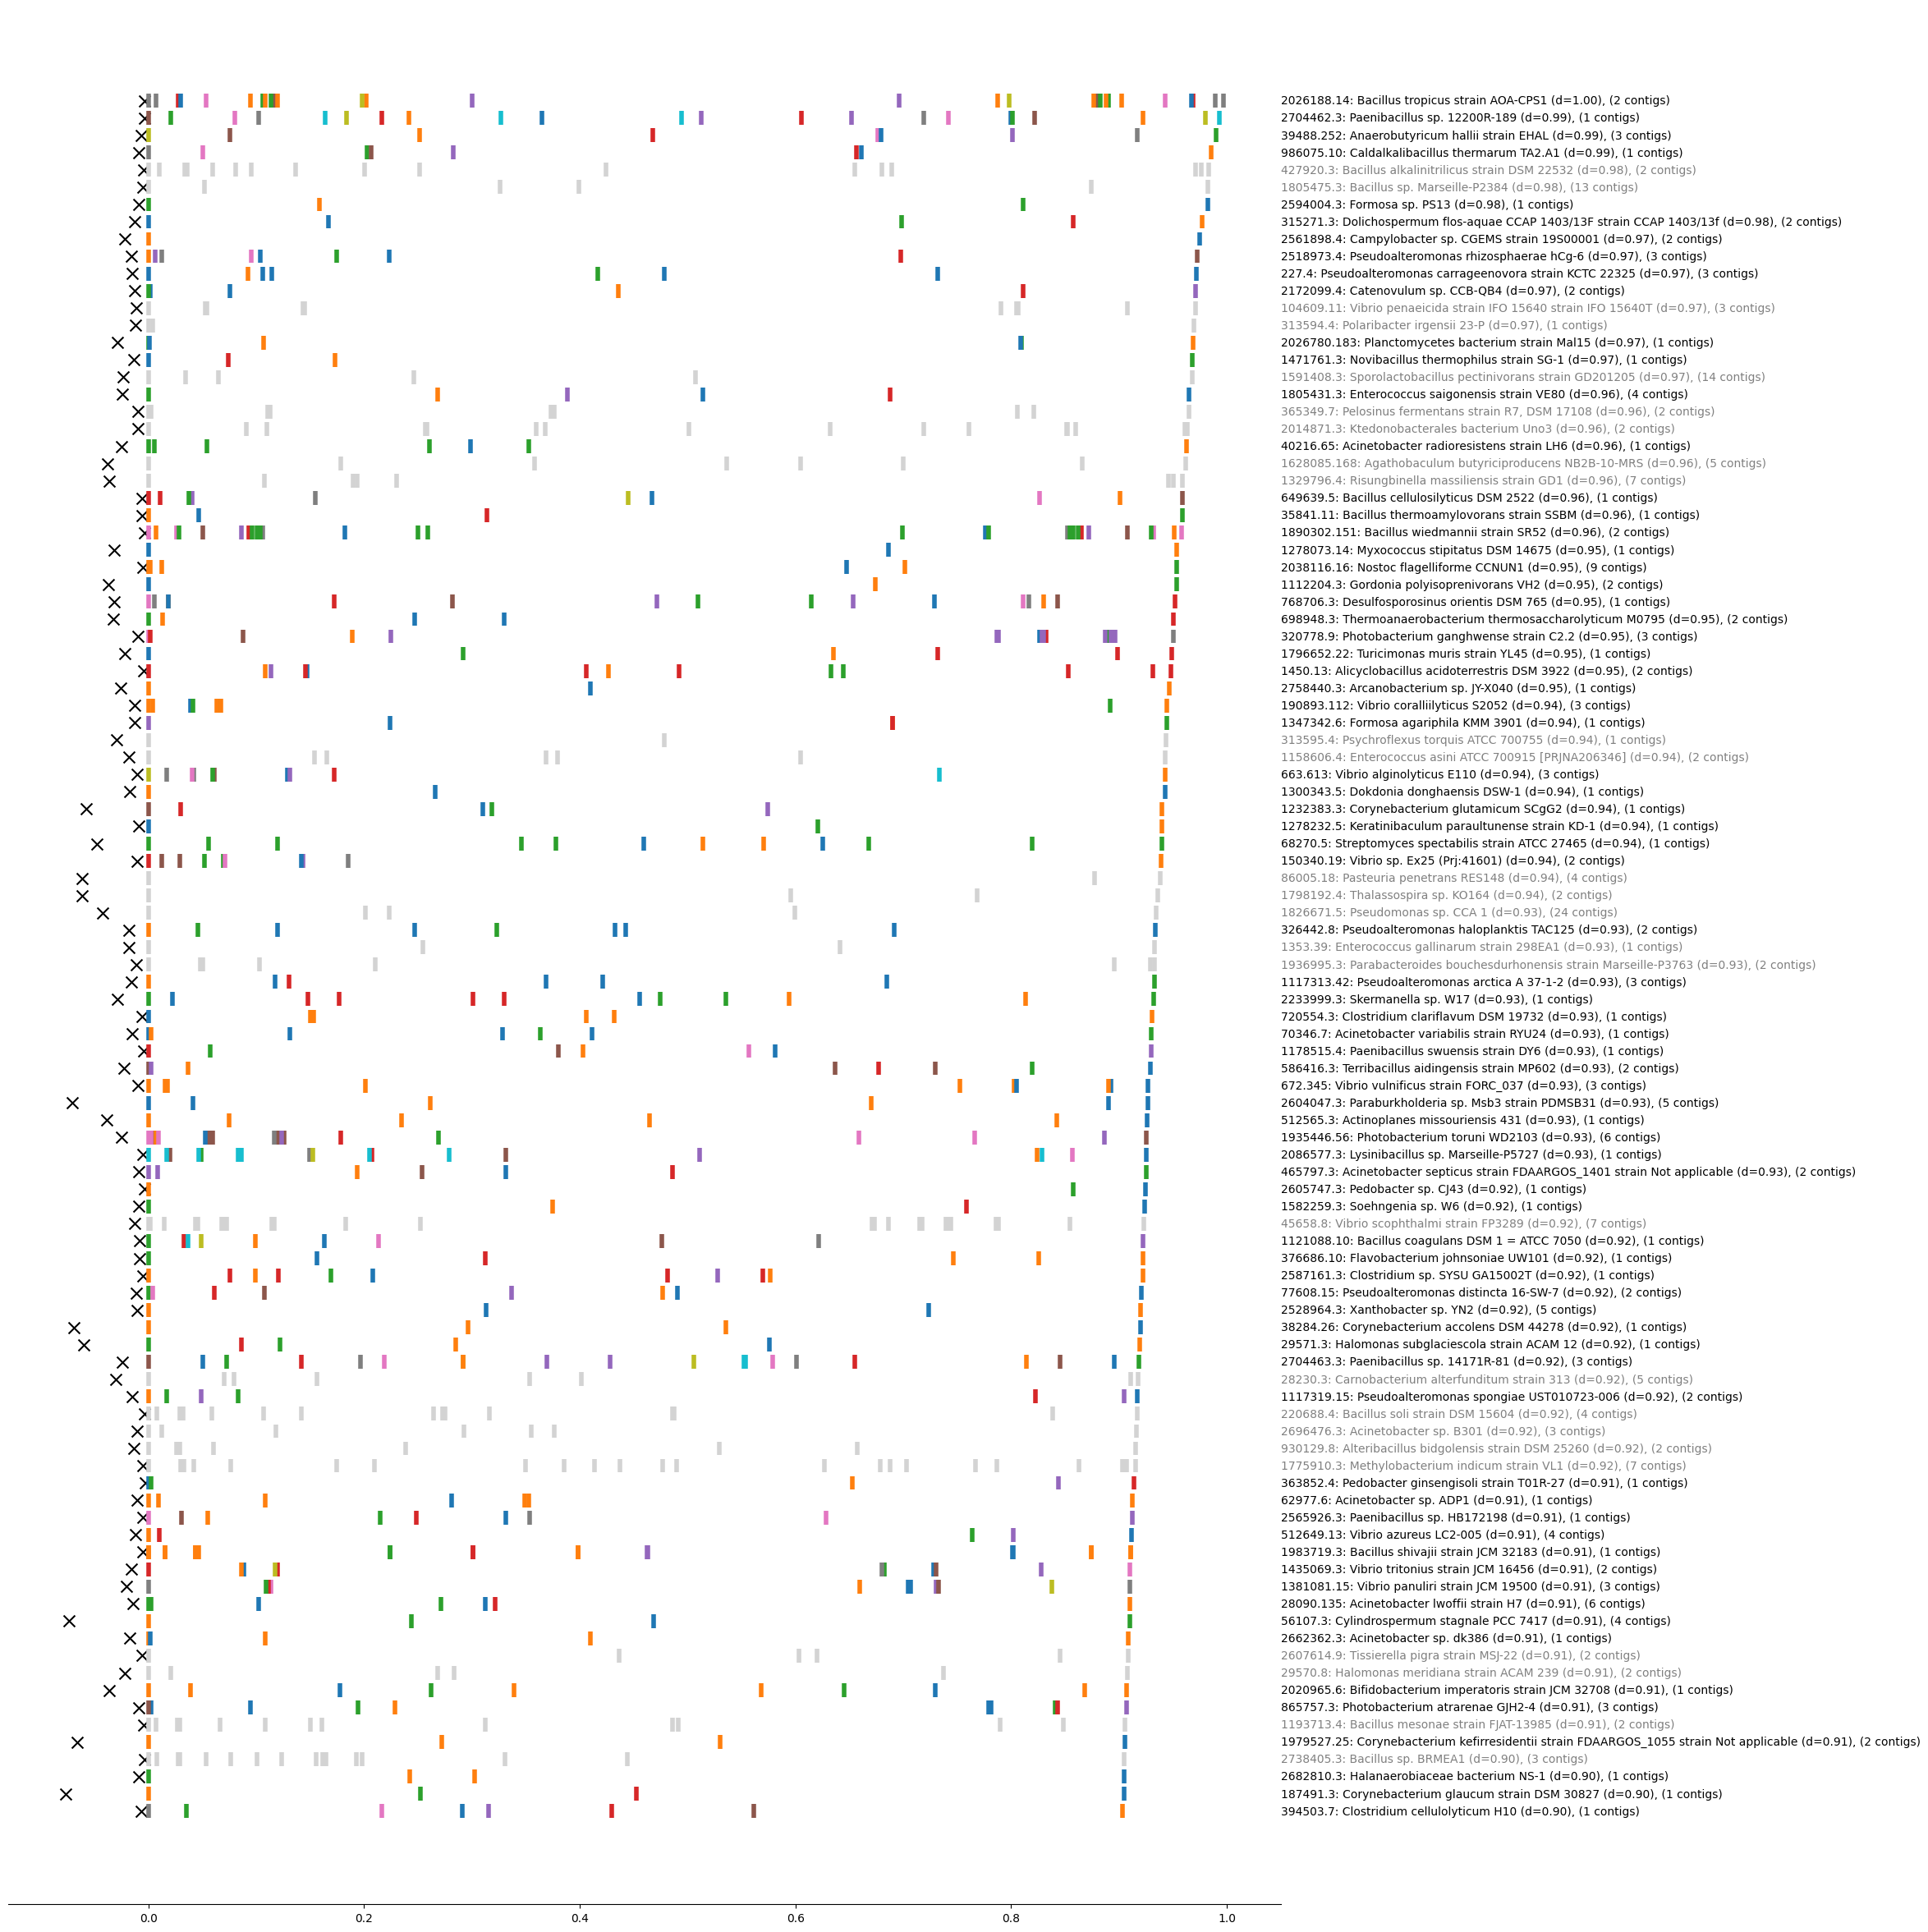

In [41]:
from matplotlib import cm


def visualize_genome(gid, height=0, dist=None, gray=False):
    g = db[gid]
    if gray:
        colors = "lightgray"
    else:
        colors = cm.tab10(g["md5"].astype("category").cat.codes)
    name = g["genome_name"].iloc[0]
    n_contigs = g["n_contigs"].iloc[0]
    offset = g["oor_distance"].min()
    plt.vlines(g["oor_distance"] - offset, -height - 0.4, -height + 0.4, colors=colors, lw=4)
    plt.scatter(-offset, -height, color="black", s=100, marker="x")
    if gray:
        plt.text(1.05, -height, f"{gid}: {name} (d={dist:.2f}), ({n_contigs} contigs)", ha="left", va="center", color="gray")
    else:
        plt.text(1.05, -height, f"{gid}: {name} (d={dist:.2f}), ({n_contigs} contigs)", ha="left", va="center")


fig, ax = plt.subplots(figsize=(20, 30))
for i, gid in enumerate(best_spreads.iloc[:100].index):
    if gid in complete_genomes.index:
        visualize_genome(gid, i, best_spreads[gid])
    else:
        # Strike out
        visualize_genome(gid, i, best_spreads[gid], gray=True)
        # plt.plot([-0.1, 1], [-i, -i], color="black", lw=2)

# Turn off left/right spines and y axis labels
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.yticks([])
plt.show()